<a href="https://colab.research.google.com/github/Abderrahmane-Br/Hybrid-model-for-time-series-forecasting/blob/CNN-LSTM/cnn1d_lstm_slide_size_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# elect_data = pd.read_csv("/content/BrentSpotPrice.csv", index_col="Date")
# elect_data = pd.read_csv("/content/AirPassengers.csv", index_col="Month")
# elect_data = pd.read_csv("/content/Electric_Production.csv", index_col="DATE")
elect_data = pd.read_csv("/content/MedicineData.csv", index_col="date")
# elect_data = pd.read_csv("/content/S&P500.csv", index_col="Date")
# elect_data = pd.read_csv("/content/YearlySunspots.csv", usecols=["time", "value"], index_col="time", parse_dates=True)
# elect_data = pd.read_csv("/content/covid_day_wise.csv", usecols=["Date", "New deaths"], index_col="Date")
# elect_data = pd.read_csv("/content/PDB_Load_History.csv", usecols=["date", "demand"], index_col="date")
# elect_data = pd.read_csv("/content/daily-total-female-births-CA.csv", index_col="date")
# elect_data.index = pd.to_datetime(elect_data.index)


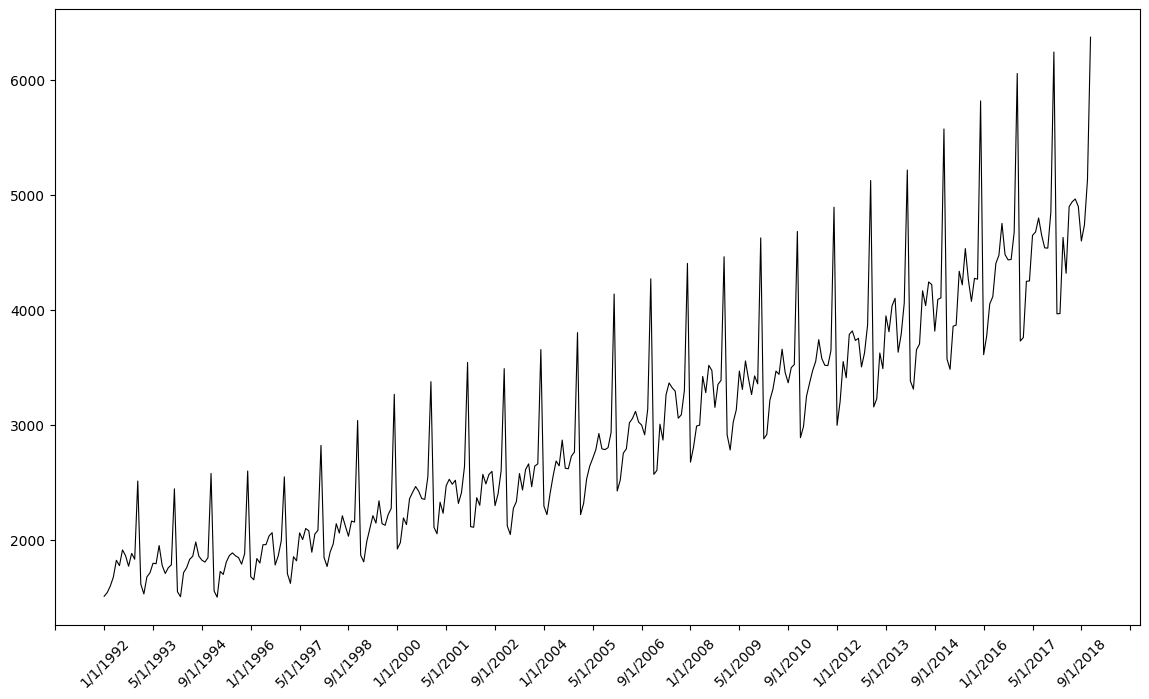

In [ ]:
import matplotlib.ticker as ticker
def plot_data(data_axis, data_vals, data_params,title="", xlabel="", ylabel="", legend=[], grid=False):
  plt.rcParams["figure.figsize"] = [14, 8]

  loc_size = int(len(data_axis)*5/100)
  fig, ax = plt.subplots()
  if (loc_size > 0):
    loc = ticker.MultipleLocator(loc_size)
    ax.xaxis.set_major_locator(loc)
  # ax.xaxis.set_minor_locator(min_loc)
  ax.tick_params(colors="black")
  plt.xticks(rotation=45)
  plt.grid(grid)

  for i in range(len(data_vals)):
    style = data_params[i][0]
    color = data_params[i][-1]
    linewidth = data_params[i][-2]
    ax.plot(data_axis, data_vals[i], style, color=color, linewidth=linewidth)

plot_data(elect_data.index, [elect_data.iloc[:,0]], [["-", 0.8, "black"]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(elect_data)
train_scaled = scaler.transform(elect_data)
split_point = int(len(train_scaled) * 0.7)
train_set = torch.tensor(train_scaled[:split_point], dtype=torch.float32)
test_set = torch.tensor(train_scaled[split_point:], dtype=torch.float32)

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, kernel_size, output_size=1):
        super().__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size

        self.conv = nn.Conv1d(1, 1, kernel_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, input):
        conv_out = self.conv(input.permute(1, 0)).squeeze(0)
        lstm_out, (hidden, cell) = self.lstm(conv_out.view(len(conv_out), 1))
        out = self.linear(lstm_out[-self.output_size:])
        
        return out

In [ ]:
def slide(model, optimizer, sequence, lookback, horizon): 

  seq_len = len(sequence)
  results = torch.empty(0)
  i = 0
  while(i <= seq_len - lookback - horizon):
    out = model(sequence[i:i+lookback])
    loss = loss_fun(out, sequence[i+lookback: i+lookback+horizon])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    results = torch.cat((results, out))
    i+= horizon


  # handling last forecast where the horizon goes beyond sequence length

  extra_len = horizon - (seq_len - lookback) % horizon
  out = model(sequence[i:i+lookback])[:-extra_len]
  loss = loss_fun(out, sequence[i+lookback:i+lookback+horizon-extra_len])
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  results = torch.cat((results, out))

  return results

In [ ]:
lookback = 20
horizon = 8
model = CNN_LSTM(1, 25, 1, 4, horizon)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
loss_fun = nn.MSELoss()
epochs = 250

In [ ]:
test_tn = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,16, 17, 18, 19, 20], dtype=torch.float32).reshape(-1, 1)
results = []
train_error = []
for epoch in range(epochs): 
  # results = np.array(slide(model, optimizer, test_tn, lookback, horizon).detach())
  results = np.array(slide(model, optimizer, train_set, lookback, horizon).detach())
  train_error.append(np.mean(train_scaled[lookback:split_point]-results))

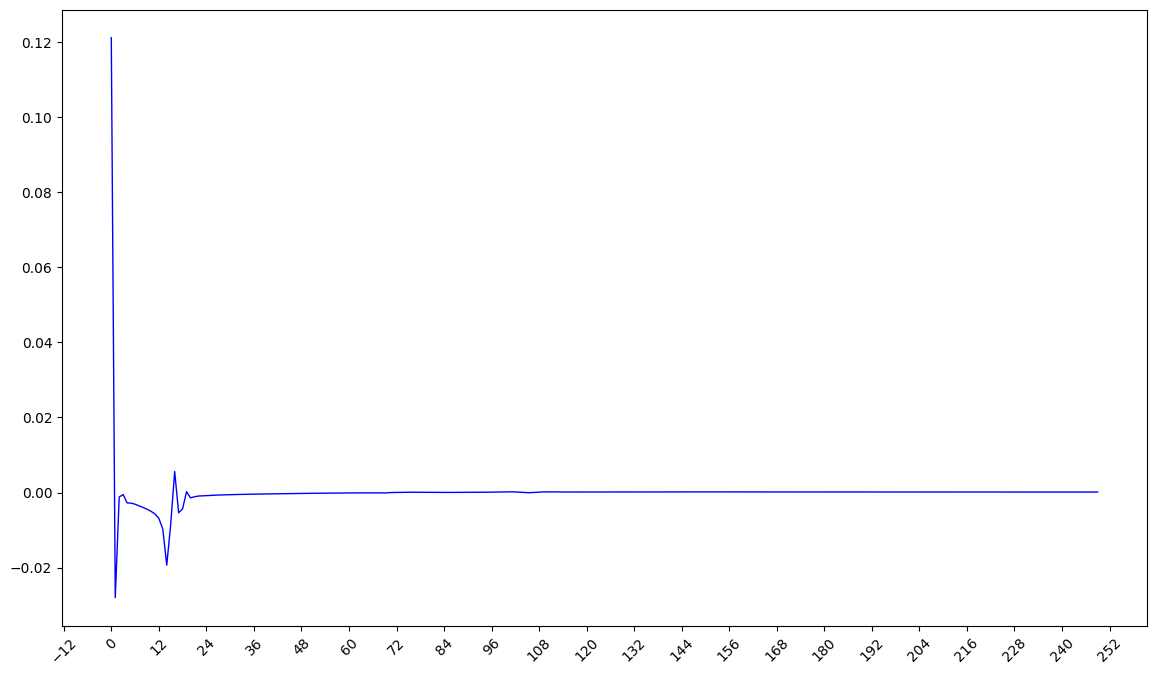

In [ ]:
plot_data(np.arange(epochs), [train_error], [["-", 1, "blue"]])

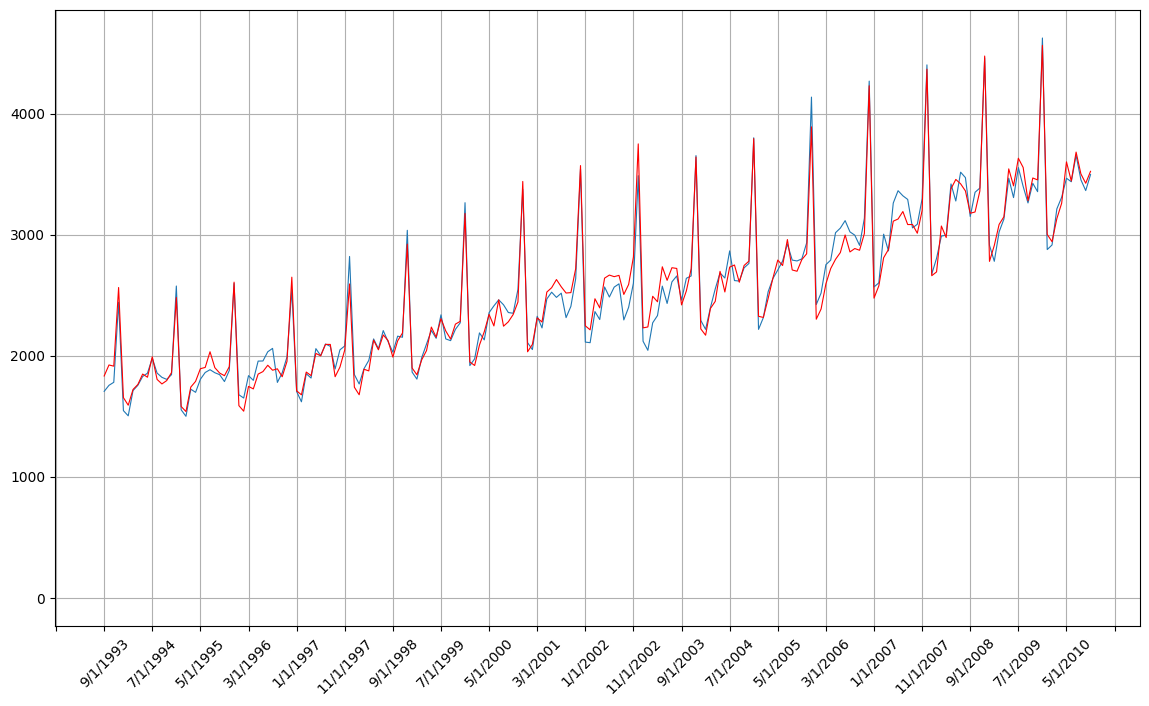

In [ ]:
scaled_res = scaler.inverse_transform(np.array(results).reshape(-1, 1)).squeeze(-1)
original_data =elect_data.iloc[:,0][lookback:split_point]
data_index = index=elect_data.index[lookback:split_point]
plot_params = [[0.8, None], [0.8, "red"]]
legend = ["Actual", "Pred"]
plot_data(data_index, [original_data, scaled_res], plot_params, legend=legend, grid=True)
plt.rcParams["figure.figsize"] = [18, 5]

In [ ]:
slide_test_set = torch.cat((train_set[-lookback:], test_set))
slide_test_out = slide(model, optimizer, slide_test_set, lookback, horizon).detach()

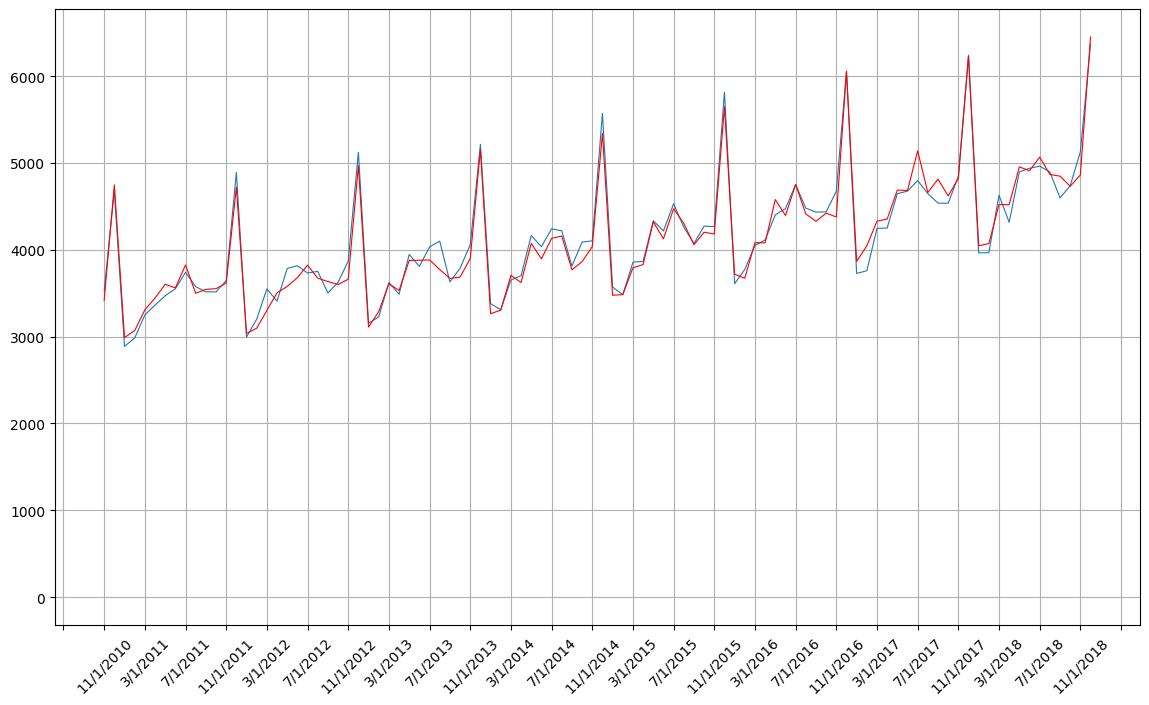

In [ ]:
scaled_res = scaler.inverse_transform(np.array(slide_test_out).reshape(-1, 1))
original_data =elect_data.iloc[:,0][split_point:]
data_index = index=elect_data.index[split_point:]
plot_params = [[0.8, None], [0.8, "red"]]
legend = ["Actual", "Pred"]
plot_data(data_index, [original_data, scaled_res], plot_params, legend=legend, grid=True)


In [ ]:
# con = nn.Conv1d(1, 1, 3)
# tn = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,11, 12, 13, 14, 15], dtype=torch.float32)
# out = con(tn.unsqueeze(0))
# print(out.squeeze(0))

In [ ]:
# lstm = nn.LSTM(1, 5, 1)
# tn = torch.tensor([1, 2, 3, 4, 5, 6], dtype=torch.float32)
# out, _ = lstm(tn.view(6, 1))
# print(out)

# lin = nn.Linear(5, 1)
# print(lin(out))


In [ ]:
from math import sqrt

def calc_errors(actual, pred):
  mse = np.mean((actual - pred) **2)
  mrse = sqrt(mse)
  mae = np.mean(np.abs(actual - pred))
  mape = np.mean((actual - pred)/actual)

  return {"MSE": mse, "MRSE": mrse, "MAE": mae, "MAPE": mape}


from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def calc_errors_skl(actual, pred):
  mse = mean_squared_error(actual, pred)
  mrse = sqrt(mse)
  mae = mean_absolute_error(actual, pred)
  mape = mean_absolute_percentage_error(actual, pred)

  return {"MSE": mse, "MRSE": mrse, "MAE": mae, "MAPE": mape}

print(calc_errors(np.array(test_set), np.array(slide_test_out)))

{'MSE': 0.0006444246, 'MRSE': 0.025385519119547593, 'MAE': 0.019796573, 'MAPE': 0.0048050014}


Text(0.5, 1.0, 'covid new deaths dataset')

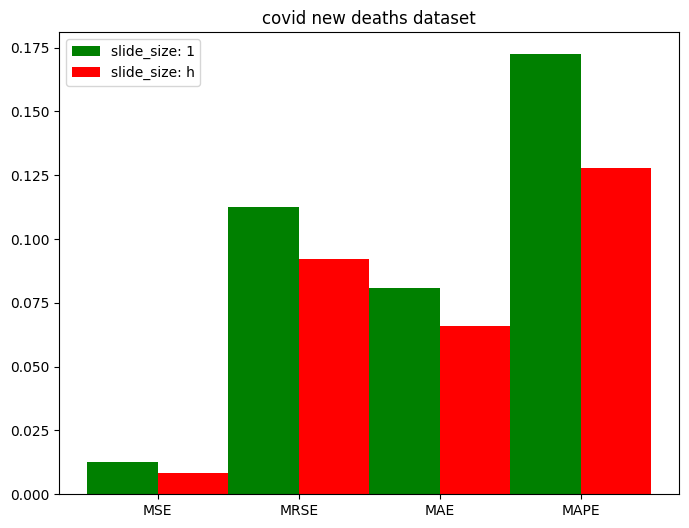

In [ ]:
cov_com = [
    {'MSE': 0.012661133, 'MRSE': 0.11252169995832631, 'MAE': 0.08072974, 'MAPE': 0.17240804},
    {'MSE': 0.0084707085, 'MRSE': 0.09203645204112983, 'MAE': 0.0661222, 'MAPE': 0.12791829}
]
plt.rcParams["figure.figsize"] = [8, 6]
errs = np.array(list(map(lambda x: list(x.values()), cov_com)))
plt.bar(np.arange(4)-0.25, errs[0, :], width=0.5, color="green")
plt.bar(np.arange(4)+0.25, errs[1, :], width=0.5, color="red")
plt.legend(["slide_size: 1", "slide_size: h"])
plt.xticks(np.arange(4), ["MSE", "MRSE", "MAE", "MAPE"])
plt.title("covid new deaths dataset")

Text(0.5, 1.0, 'air passengers dataset')

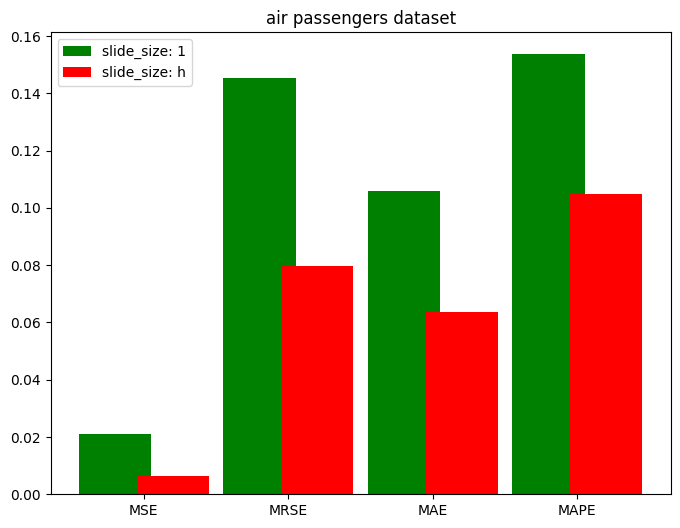

In [ ]:
air_com = [
    {'MSE': 0.021120615, 'MRSE': 0.1453293339402489, 'MAE': 0.105816886, 'MAPE': 0.1536533},
    {'MSE': 0.006337884, 'MRSE': 0.07961082766951089, 'MAE': 0.06371867, 'MAPE': 0.10469024}
]
plt.rcParams["figure.figsize"] = [8, 6]
errs = np.array(list(map(lambda x: list(x.values()), air_com)))
plt.bar(np.arange(4)-0.2, errs[0, :], width=0.5, color="green")
plt.bar(np.arange(4)+0.2, errs[1, :], width=0.5, color="red")
plt.legend(["slide_size: 1", "slide_size: h"])
plt.xticks(np.arange(4), ["MSE", "MRSE", "MAE", "MAPE"])
plt.title("air passengers dataset")

Text(0.5, 1.0, 'medicine sales dataset dataset')

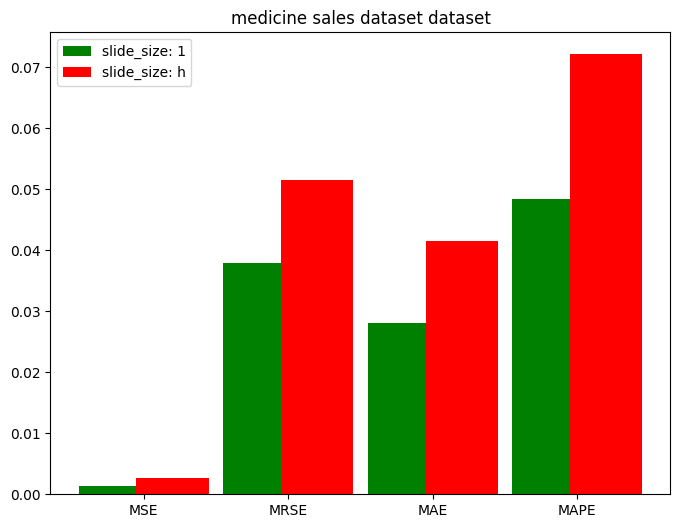

In [ ]:
medc_com = [
    {'MSE': 0.001436681, 'MRSE': 0.037903575306360154, 'MAE': 0.028001267, 'MAPE': 0.04840245},
{'MSE': 0.0026500453, 'MRSE': 0.051478590929792796, 'MAE': 0.041567355, 'MAPE': 0.07207676}
]
errs = np.array(list(map(lambda x: list(x.values()), medc_com)))

plt.rcParams["figure.figsize"] = [8, 6]
plt.bar(np.arange(4)-0.2, errs[0, :], width=0.5, color="green")
plt.bar(np.arange(4)+0.2, errs[1, :], width=0.5, color="red")
plt.legend(["slide_size: 1", "slide_size: h"])
plt.xticks(np.arange(4), ["MSE", "MRSE", "MAE", "MAPE"])
plt.title("medicine sales dataset dataset")

Text(0.5, 1.0, 'births dataset')

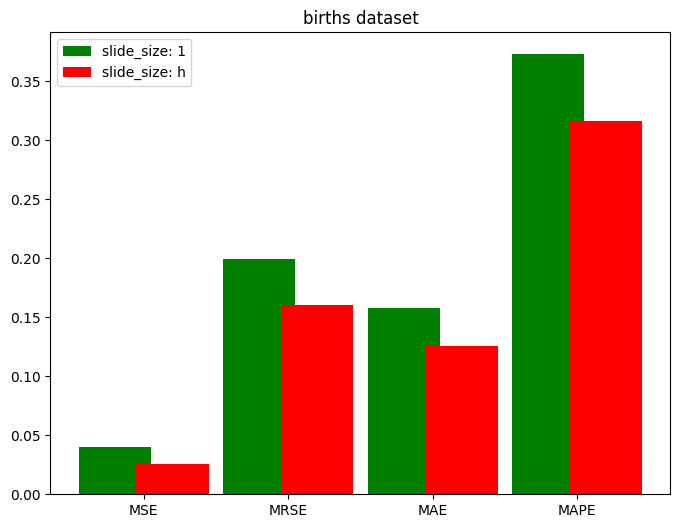

In [ ]:
births_com = [
    {'MSE': 0.039768077, 'MRSE': 0.19941935069874558, 'MAE': 0.15799136, 'MAPE': 0.3727239},
{'MSE': 0.02579395, 'MRSE': 0.16060494743966772, 'MAE': 0.12532344, 'MAPE': 0.31596267}
]
errs = np.array(list(map(lambda x: list(x.values()), births_com)))

plt.rcParams["figure.figsize"] = [8, 6]
plt.bar(np.arange(4)-0.2, errs[0, :], width=0.5, color="green")
plt.bar(np.arange(4)+0.2, errs[1, :], width=0.5, color="red")
plt.legend(["slide_size: 1", "slide_size: h"])
plt.xticks(np.arange(4), ["MSE", "MRSE", "MAE", "MAPE"])
plt.title("births dataset")

In [ ]:
# Air data stride= horizon

# [{'num_lstm': 1, 'k': 2, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.020367913, 'MRSE': 0.1427161972171749, 'MAE': 0.113777, 'MAPE': 0.18895496}}
#  {'num_lstm': 1, 'k': 3, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.006337884, 'MRSE': 0.07961082766951089, 'MAE': 0.06371867, 'MAPE': 0.10469024}}***
#  {'num_lstm': 1, 'k': 4, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.012717324, 'MRSE': 0.1127711146927751, 'MAE': 0.09422993, 'MAPE': 0.15958165}}
#  {'num_lstm': 1, 'k': 5, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.020074842, 'MRSE': 0.14168571733843327, 'MAE': 0.1210284, 'MAPE': 0.20593901}}
#  {'num_lstm': 2, 'k': 2, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.019810265, 'MRSE': 0.1407489429094551, 'MAE': 0.11030995, 'MAPE': 0.16710562}}
#  {'num_lstm': 2, 'k': 3, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.011509281, 'MRSE': 0.10728131548320884, 'MAE': 0.08343749, 'MAPE': 0.13261671}}*
#  {'num_lstm': 2, 'k': 4, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.05654861, 'MRSE': 0.2377995170929243, 'MAE': 0.19331284, 'MAPE': 0.28641844}}
#  {'num_lstm': 2, 'k': 5, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.010715603, 'MRSE': 0.10351619630332058, 'MAE': 0.08066832, 'MAPE': 0.12820707}}]**

In [ ]:
# med data stride = horizon
# [{'num_lstm': 1, 'k': 2, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.015710682, 'MRSE': 0.1253422581449075, 'MAE': 0.0932859, 'MAPE': 0.15384759}}
#  {'num_lstm': 1, 'k': 3, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.008813982, 'MRSE': 0.09388280938557914, 'MAE': 0.066656455, 'MAPE': 0.10780135}}*
#  {'num_lstm': 1, 'k': 4, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.0026500453, 'MRSE': 0.051478590929792796, 'MAE': 0.041567355, 'MAPE': 0.07207676}}***
#  {'num_lstm': 1, 'k': 5, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.0033425074, 'MRSE': 0.05781442213729379, 'MAE': 0.045793258, 'MAPE': 0.077359654}}**
#  {'num_lstm': 2, 'k': 2, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.01985953, 'MRSE': 0.14092384479455938, 'MAE': 0.10668127, 'MAPE': 0.1755302}}
#  {'num_lstm': 2, 'k': 3, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.011996928, 'MRSE': 0.10953048740480649, 'MAE': 0.08761907, 'MAPE': 0.14670517}}
#  {'num_lstm': 2, 'k': 4, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.015212727, 'MRSE': 0.12333988316551177, 'MAE': 0.09536699, 'MAPE': 0.15575786}}
#  {'num_lstm': 2, 'k': 5, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.019881701, 'MRSE': 0.14100248613727476, 'MAE': 0.10887979, 'MAPE': 0.17894508}}]

In [ ]:
# Covid new deaths stride=horizon

# [{'num_lstm': 1, 'k': 2, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.010306707, 'MRSE': 0.1015219515772094, 'MAE': 0.07452674, 'MAPE': 0.14311545}}
#  {'num_lstm': 1, 'k': 3, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.0084707085, 'MRSE': 0.09203645204112983, 'MAE': 0.0661222, 'MAPE': 0.12791829}}***
#  {'num_lstm': 1, 'k': 4, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.008960989, 'MRSE': 0.09466250210028726, 'MAE': 0.07059274, 'MAPE': 0.13743506}}**
#  {'num_lstm': 1, 'k': 5, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.009141661, 'MRSE': 0.09561203494722524, 'MAE': 0.0706667, 'MAPE': 0.1382582}}*
#  {'num_lstm': 2, 'k': 2, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.010016006, 'MRSE': 0.10008000008779226, 'MAE': 0.07660334, 'MAPE': 0.15612216}}
#  {'num_lstm': 2, 'k': 3, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.011120777, 'MRSE': 0.10545509302939908, 'MAE': 0.07735657, 'MAPE': 0.14914884}}
#  {'num_lstm': 2, 'k': 4, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.012578549, 'MRSE': 0.1121541299441539, 'MAE': 0.083818, 'MAPE': 0.16023973}}
#  {'num_lstm': 2, 'k': 5, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.013761731, 'MRSE': 0.11731040390623523, 'MAE': 0.09073598, 'MAPE': 0.17717932}}]

In [ ]:
# daily total births stride=horizon
# [{'num_lstm': 1, 'k': 2, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.02579395, 'MRSE': 0.16060494743966772, 'MAE': 0.12532344, 'MAPE': 0.31596267}}***
#  {'num_lstm': 1, 'k': 3, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.026703745, 'MRSE': 0.16341280588351773, 'MAE': 0.12785001, 'MAPE': 0.3256576}}**
#  {'num_lstm': 1, 'k': 4, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.027423743, 'MRSE': 0.16560115687572619, 'MAE': 0.12779242, 'MAPE': 0.30834436}}**
#  {'num_lstm': 1, 'k': 5, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.026943613, 'MRSE': 0.1641450969226675, 'MAE': 0.12661956, 'MAPE': 0.30856618}}**
#  {'num_lstm': 2, 'k': 2, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.028158614, 'MRSE': 0.16780528719903348, 'MAE': 0.13146272, 'MAPE': 0.3245068}}
#  {'num_lstm': 2, 'k': 3, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.028035596, 'MRSE': 0.1674383349566913, 'MAE': 0.13173795, 'MAPE': 0.31666777}}
#  {'num_lstm': 2, 'k': 4, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.032513864, 'MRSE': 0.18031601242928477, 'MAE': 0.14666604, 'MAPE': 0.37393588}}
#  {'num_lstm': 2, 'k': 5, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.029634714, 'MRSE': 0.17214736166025582, 'MAE': 0.13676205, 'MAPE': 0.34403694}}]

In [ ]:
# Medicine data stride 1
# [{'num_lstm': 1, 'k': 2, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.018416753, 'MRSE': 0.13570833813279123, 'MAE': 0.092309326, 'MAPE': 0.14431258}}
#  {'num_lstm': 1, 'k': 3, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.04387418, 'MRSE': 0.20946164758026986, 'MAE': 0.15771969, 'MAPE': 0.25408092}}
#  {'num_lstm': 1, 'k': 4, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.017472675, 'MRSE': 0.13218424667927184, 'MAE': 0.106163785, 'MAPE': 0.17724925}}
#  {'num_lstm': 1, 'k': 5, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.001436681, 'MRSE': 0.037903575306360154, 'MAE': 0.028001267, 'MAPE': 0.04840245}}***
#  {'num_lstm': 2, 'k': 2, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.02494686, 'MRSE': 0.15794574735149242, 'MAE': 0.112472385, 'MAPE': 0.17962545}}
#  {'num_lstm': 2, 'k': 3, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.04075182, 'MRSE': 0.2018707967178869, 'MAE': 0.15338688, 'MAPE': 0.24703185}}
#  {'num_lstm': 2, 'k': 4, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.031166127, 'MRSE': 0.1765393071006434, 'MAE': 0.12594482, 'MAPE': 0.19899383}}
#  {'num_lstm': 2, 'k': 5, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.01462545, 'MRSE': 0.12093572534570075, 'MAE': 0.09517861, 'MAPE': 0.1618978}}]

In [ ]:
# Air data stride 1
# [{'num_lstm': 1, 'k': 2, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.035110794, 'MRSE': 0.18737874481322092, 'MAE': 0.13116068, 'MAPE': 0.1865261}}
#  {'num_lstm': 1, 'k': 3, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.052145187, 'MRSE': 0.22835320626539396, 'MAE': 0.16700697, 'MAPE': 0.23898467}}
#  {'num_lstm': 1, 'k': 4, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.04237786, 'MRSE': 0.20585883355838575, 'MAE': 0.15300485, 'MAPE': 0.21651997}}
#  {'num_lstm': 1, 'k': 5, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.021120615, 'MRSE': 0.1453293339402489, 'MAE': 0.105816886, 'MAPE': 0.1536533}}***
#  {'num_lstm': 2, 'k': 2, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.04934143, 'MRSE': 0.2221293069924245, 'MAE': 0.1618433, 'MAPE': 0.23630224}}
#  {'num_lstm': 2, 'k': 3, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.03500514, 'MRSE': 0.1870966088672467, 'MAE': 0.14071758, 'MAPE': 0.20356289}}
#  {'num_lstm': 2, 'k': 4, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.041502375, 'MRSE': 0.20372131738158217, 'MAE': 0.1563896, 'MAPE': 0.23194446}}
#  {'num_lstm': 2, 'k': 5, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.037944015, 'MRSE': 0.19479223576800872, 'MAE': 0.14142278, 'MAPE': 0.20180637}}]

In [ ]:
# Covid new deaths dataset stride = 1
# [{'num_lstm': 1, 'k': 2, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.01636395, 'MRSE': 0.12792165745583528, 'MAE': 0.09106379, 'MAPE': 0.19011807}}
#  {'num_lstm': 1, 'k': 3, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.016471926, 'MRSE': 0.12834300184623945, 'MAE': 0.09612572, 'MAPE': 0.20588131}}
#  {'num_lstm': 1, 'k': 4, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.016688552, 'MRSE': 0.12918417764478507, 'MAE': 0.10109432, 'MAPE': 0.21845396}}
#  {'num_lstm': 1, 'k': 5, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.016383672, 'MRSE': 0.12799871926346806, 'MAE': 0.096159406, 'MAPE': 0.20340568}}
#  {'num_lstm': 2, 'k': 2, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.012661133, 'MRSE': 0.11252169995832631, 'MAE': 0.08072974, 'MAPE': 0.17240804}}***
#  {'num_lstm': 2, 'k': 3, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.014722199, 'MRSE': 0.12133506986536136, 'MAE': 0.08456488, 'MAPE': 0.173049}}*
#  {'num_lstm': 2, 'k': 4, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.01532909, 'MRSE': 0.12381070206991336, 'MAE': 0.09233491, 'MAPE': 0.19991338}}
#  {'num_lstm': 2, 'k': 5, 'lb': 15, 'h': 5, 'errs': {'MSE': 0.012724041, 'MRSE': 0.1128008909869916, 'MAE': 0.08227949, 'MAPE': 0.17344362}}]**

In [ ]:
# births dataset stride = 1
# [{'num_lstm': 1, 'k': 2, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.05549817, 'MRSE': 0.2355804991881102, 'MAE': 0.191468, 'MAPE': 0.46598476}}
#  {'num_lstm': 1, 'k': 3, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.041760534, 'MRSE': 0.2043539430695685, 'MAE': 0.16762285, 'MAPE': 0.4233567}}
#  {'num_lstm': 1, 'k': 4, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.05403139, 'MRSE': 0.2324465329850372, 'MAE': 0.19018736, 'MAPE': 0.50639427}}
#  {'num_lstm': 1, 'k': 5, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.052860174, 'MRSE': 0.22991340615129158, 'MAE': 0.17759542, 'MAPE': 0.43962118}}
#  {'num_lstm': 2, 'k': 2, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.044526912, 'MRSE': 0.211014009658071, 'MAE': 0.15950678, 'MAPE': 0.36623052}}
#  {'num_lstm': 2, 'k': 3, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.039768077, 'MRSE': 0.19941935069874558, 'MAE': 0.15799136, 'MAPE': 0.3727239}}***
#  {'num_lstm': 2, 'k': 4, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.044677302, 'MRSE': 0.21137005994540803, 'MAE': 0.1701795, 'MAPE': 0.39602965}}
#  {'num_lstm': 2, 'k': 5, 'lb': 20, 'h': 8, 'errs': {'MSE': 0.0371929, 'MRSE': 0.1928546077587513, 'MAE': 0.15509078, 'MAPE': 0.35424584}}]